Devoir #2 
Entraînement et métriques de performance de 
l’apprentissage 

In [1]:
#Chargement des modules commun
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.compose import *

C:\Users\michael\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#lecture du dataset. A la lecture, les valeurs inconnues (? ) sont remplacées
#par NAN, ainsi on peut directement exploiter Imputer.
data_client = pd.read_csv('Customer.csv', na_values=['?', 'unknown'])

In [3]:
#Extraction d'un jeu d'entrainement "train_set" 80% et d'un jeu de test "test_test": 20%
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_client, test_size=0.2, 
                                       random_state=42)

In [4]:
train_set.shape

(8000, 8)

In [5]:
train_set.head()

,age,pages,first_item_prize,gender,ReBuy,News_click,country,revenue
9254,36.0,6.0,10.0,Masc,False,3.0,Ghana,14.0
1561,36.0,6.0,22.0,Masc,True,4.0,Bangladesh,66.0
1670,38.0,3.0,44.0,Fem,False,3.0,Russia,74.0
6087,36.0,4.0,15.5,Masc,False,10.0,Argentina,116.0
6669,40.0,4.0,15.5,Fem,False,7.0,Sudan,36.0


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8000 non-null   float64
 1   pages             8000 non-null   float64
 2   first_item_prize  7997 non-null   float64
 3   gender            8000 non-null   object 
 4   ReBuy             8000 non-null   bool   
 5   News_click        8000 non-null   float64
 6   country           8000 non-null   object 
 7   revenue           7997 non-null   float64
dtypes: bool(1), float64(5), object(2)
memory usage: 507.8+ KB


In [7]:
train_set.describe(include=np.number)

,age,pages,first_item_prize,News_click,revenue
count,8000.000000,8000.000000,7997.000000,8000.000000,7997.000000
mean,37.391750,6.009500,40.285044,4.403625,122.725272
std,9.480534,2.439806,27.625504,2.427179,86.444314
min,18.000000,1.000000,10.000000,0.000000,3.000000
25%,31.000000,5.000000,22.000000,3.000000,60.000000
50%,37.000000,6.000000,42.000000,4.000000,100.000000
75%,43.000000,7.000000,44.000000,6.000000,164.000000
max,79.000000,14.000000,117.000000,10.000000,995.000000


In [8]:
#visualisation
data_num = train_set.drop(["gender","ReBuy","country"], axis=1)

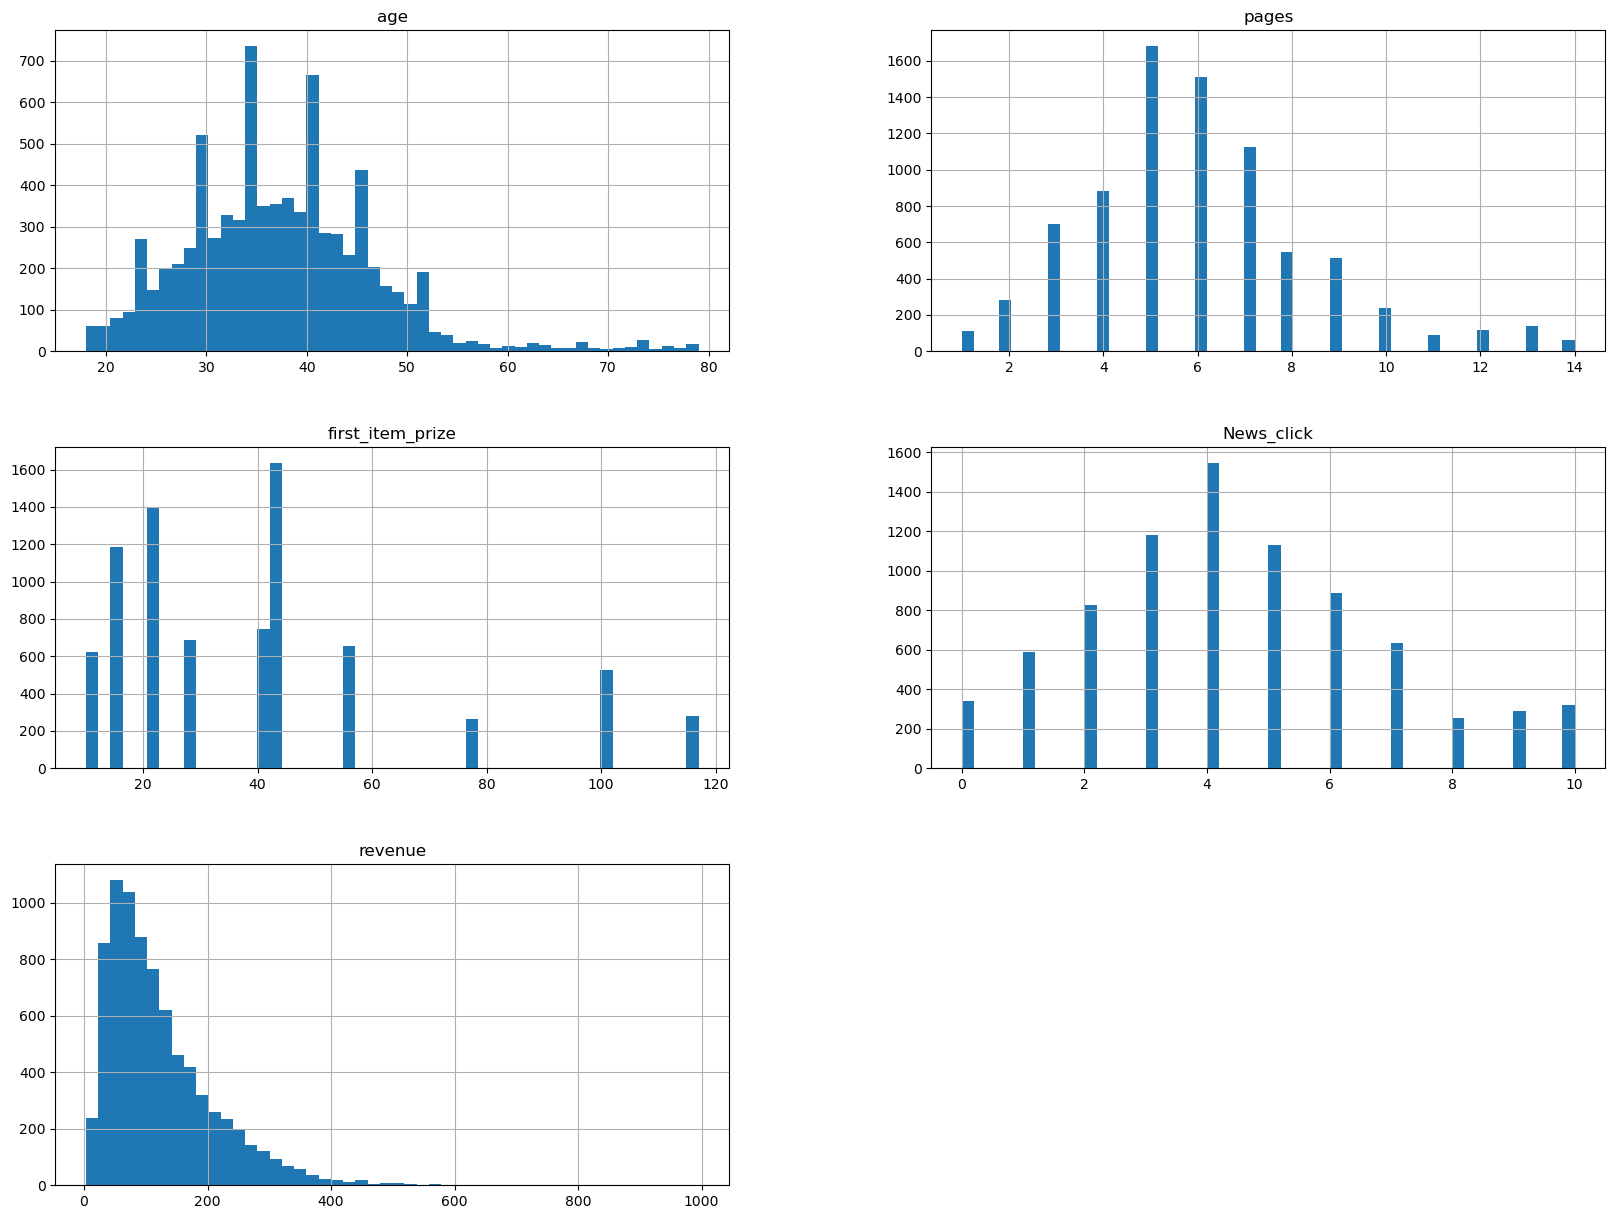

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
data_num.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: xlabel='gender'>

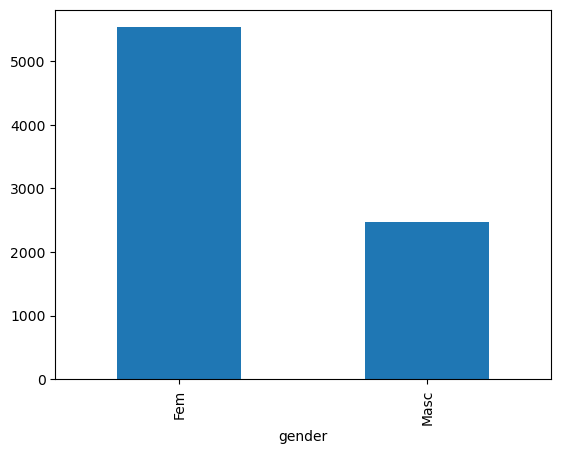

In [10]:
train_set['gender'].value_counts().plot.bar()

In [11]:
corr_matrix =data_num.corr()

In [12]:
corr_matrix['revenue'].sort_values(ascending=False)

revenue             1.000000
News_click          0.374412
first_item_prize    0.367441
age                 0.022159
pages              -0.010377
Name: revenue, dtype: float64

<Axes: >

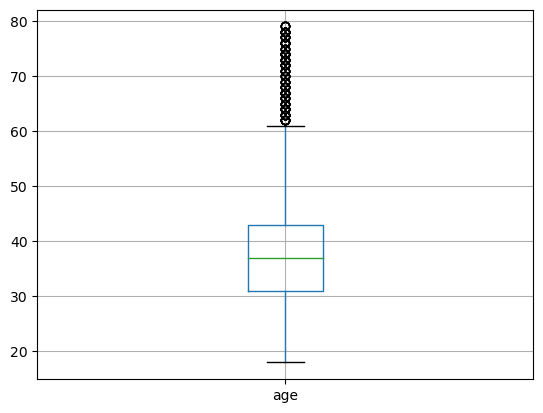

In [13]:
# Recherche des outliers...Exploration visuelle
train_set[['age']].boxplot()
# Il y plusieurs valeurs > Q3

In [14]:
#il faut séparer les entrées/sorties
X_train=train_set.drop(["revenue"], axis=1)
y_train=train_set["revenue"]

In [15]:
#remplcement des vaeurs manquantes
imputer = SimpleImputer(strategy="median")
X=imputer.fit_transform(data_num)

In [16]:
# fonction de nettoyage de données aberrantes qui sera appellee le pipeline
#utilisation de la fonction clip()
def nettoyageOutliers(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.columns
    Q25 = df[cols].quantile(0.25) #Q1 on définit le premier quartile pour c
    Q75 = df[cols].quantile(0.75)
    IQR = Q75 - Q25
    SeuilMin = (Q25 - 1.5 * IQR)
    SeuilMax= (Q75 + 1.5 * IQR)
    nouv_df = df[cols].clip(SeuilMin[cols], SeuilMax[cols], axis=1)
    return nouv_df

<Axes: >

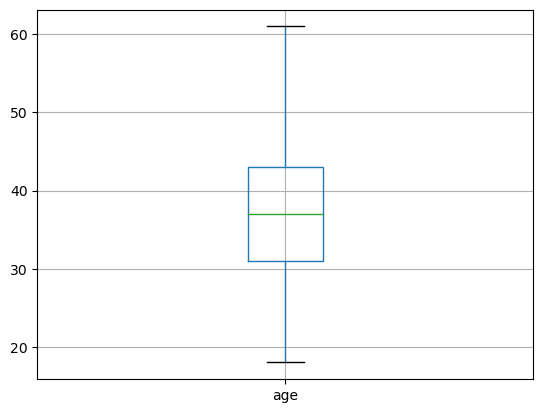

In [17]:
resultat = nettoyageOutliers(pd.DataFrame(X, columns=data_num.columns))
resultat[['age']].boxplot()

In [18]:
def bornage(data):
    return nettoyageOutliers(pd.DataFrame(data))

In [19]:
#il faut remarquer que la variable Country est ecrite en premiere lettre Capital
#C qui n'est pas la meme que celle du dataset Data écrite en minscule "country"
#important pour faire le merge
# d'ou le renommage des colonnes
data_pays = pd.read_csv("CountryPopulation.csv", na_values=['?', 'unknown'])
data_pib = pd.read_csv("CountryGDP.csv", na_values=['?', 'unknown'])
data_pays.columns=['country','population']
data_pib.columns =['country', 'GDP_inhab']

In [20]:
#definition de la fonction merge
#renommage de la colonne country

def mergeDataset(data: pd.DataFrame, pib=False):
    data_enrichie = pd.merge(data, data_pays)
    if pib==True:
        #jointure entre le data et le data_pib
        data_enrichie = data_enrichie.merge(data_pib)
    return data_enrichie

In [21]:
def toNum(data :pd.DataFrame):
    data['first_item_prize']=pd.to_numeric(data['first_item_prize'])
    return data

In [22]:
# Traitement du bruit pour les variables numériques

num_transformer = Pipeline([
    ('toNum', FunctionTransformer(toNum, validate=False)),
    # Nettoyage par remplcement de valeurs manquantes
    ('imputer', SimpleImputer(strategy="median")),
    # Remplacement des données aberrantes
    ('clamp', FunctionTransformer(bornage, validate=False))
])

In [23]:
# Transformation des variables catégorielles
cat_transformer = Pipeline([
     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [24]:
# Prépare toutes les données
preparationData = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_exclude=np.number))
    ]
)

In [25]:
# On met le tout ensemble
full_pipeline = Pipeline([
    ('merge', FunctionTransformer(mergeDataset,kw_args={"pib":True}, validate=False)),
    ('preparation', preparationData)
])

In [26]:
# Mise en oeuvre du pipeline avec les données d'entrainement pour préparer une TBA pour l'entrainement...
leData = full_pipeline.fit_transform(X_train)
pd.DataFrame(leData).head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,36.0,6.0,10.0,3.0,24658823.0,3316.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36.0,6.0,22.0,4.0,152518015.0,1963.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38.0,3.0,44.0,3.0,143700000.0,17518.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36.0,4.0,15.5,10.0,41660096.0,17917.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40.0,4.0,15.5,7.0,37964000.0,2549.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Idem le jeu de test doit être mis dans un format approprié en appliquant directement le pipeline de préparation des données
X_test=test_set.drop(["revenue"], axis=1)
y_test=test_set["revenue"]
TestData = full_pipeline.fit_transform(X_test)
pd.DataFrame(TestData).head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,54.0,3.0,15.5,3.0,38700000.0,7268.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,37.0,5.0,77.0,5.0,52981991.0,11281.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43.0,7.0,28.0,3.0,143700000.0,17518.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33.0,5.0,28.0,4.0,52981991.0,11281.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40.0,5.0,57.0,2.0,53259000.0,1612.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2.1 Classeur Binaire

2.1.1 Variable binaire

In [96]:
def create_binary_target(y, threshold=None):
    """Transforme 'revenu' en variable binaire (1 si > moyenne, 0 sinon)."""
    if threshold is None:
        threshold = y.mean()
    return np.where(y > threshold, 1, 0)

# Application sur les données
y_train_bin = create_binary_target(y_train)
y_test_bin = create_binary_target(y_test, threshold=y_train.mean())  # Éviter le data leakage

2.1.2 Échantillonnage stratifié

In [97]:
from sklearn.utils import resample

def get_scenario_data(scenario, X_data, pib=False):
    """Génère les données selon les 3 scénarios."""
    pipeline = Pipeline([
        ('merge', FunctionTransformer(mergeDataset, kw_args={"pib": pib}, validate=False)),
        ('preparation', preparationData)
    ])
    return pipeline.fit_transform(X_data)

# Génération des scénarios d'entraînement
X_train_sc1 = get_scenario_data(1, X_train, pib=False)  # Sans PIB/Population
X_train_sc2 = get_scenario_data(2, X_train, pib=False)  # Avec Population
X_train_sc3 = get_scenario_data(3, X_train, pib=True)   # Avec PIB et Population

# Échantillonnage stratifié
sample_sizes = [2000, 4000, 8000]
samples = {
    'sc1': stratified_sampling(X_train_sc1, y_train_bin, sample_sizes),
    'sc2': stratified_sampling(X_train_sc2, y_train_bin, sample_sizes),
    'sc3': stratified_sampling(X_train_sc3, y_train_bin, sample_sizes)
}

2.1.3 Validation croisée (k=3 et k=10)

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

k_values = [3, 10]
cv_results = {}
for scenario in ['sc1', 'sc2', 'sc3']:
    for size in sample_sizes:
        X, y = samples[scenario][size]
        model = DecisionTreeClassifier(random_state=42)
        scores_k3 = cross_val_score(model, X, y, cv=3, scoring='f1')
        scores_k10 = cross_val_score(model, X, y, cv=10, scoring='f1')
        cv_results[f"{scenario}_{size}"] = {
            'k=3': np.mean(scores_k3),
            'k=10': np.mean(scores_k10)
        }

2.1.4 Mesure des métriques

In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Exemple pour le scénario 1 (2000 observations)
model = DecisionTreeClassifier(random_state=42)
model.fit(samples['sc1'][2000][0], samples['sc1'][2000][1])
y_pred = model.predict(X_test_sc1)

print("Précision :", precision_score(y_test_bin, y_pred))
print("Rappel :", recall_score(y_test_bin, y_pred))
print("F1 :", f1_score(y_test_bin, y_pred))

Précision : 0.725925925925926
Rappel : 0.7757255936675461
F1 : 0.75


2.1.5 GridSearchCV

In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

best_models = {}
for scenario in ['sc1', 'sc2', 'sc3']:
    X, y = samples[scenario][8000]  # Plus grand échantillon
    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=5,  # k=5 identifié comme optimal
        scoring='f1'
    )
    grid_search.fit(X, y)
    best_models[scenario] = grid_search.best_estimator_

2.1.6 Test final

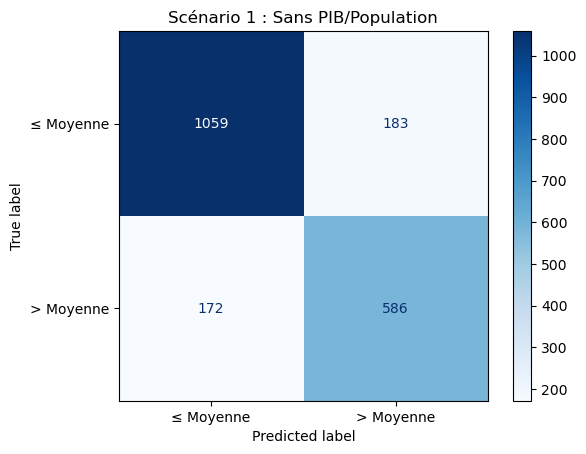

=== SCÉNARIO 1 (Customer uniquement) ===
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1242
           1       0.76      0.77      0.77       758

    accuracy                           0.82      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.82      0.82      0.82      2000



In [87]:
# === Scénario 1 : Customer uniquement ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Prédictions
y_pred_sc1 = best_models['sc1'].predict(X_test_sc1)

# Matrice de confusion
cm_sc1 = confusion_matrix(y_test_bin, y_pred_sc1)
disp_sc1 = ConfusionMatrixDisplay(cm_sc1, display_labels=["≤ Moyenne", "> Moyenne"])
disp_sc1.plot(cmap="Blues")
plt.title("Scénario 1 : Sans PIB/Population")
plt.grid(False)
plt.show()

# Rapport de classification
print("\033[1m=== SCÉNARIO 1 (Customer uniquement) ===\033[0m")
print(classification_report(y_test_bin, y_pred_sc1))

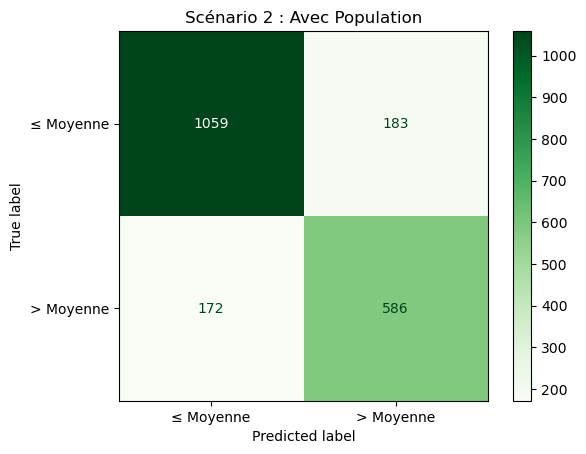

=== SCÉNARIO 2 (Customer + Population) ===
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1242
           1       0.76      0.77      0.77       758

    accuracy                           0.82      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.82      0.82      0.82      2000



In [88]:
# === Scénario 2 : Customer + Population ===
# Prédictions
y_pred_sc2 = best_models['sc2'].predict(X_test_sc2)

# Matrice de confusion
cm_sc2 = confusion_matrix(y_test_bin, y_pred_sc2)
disp_sc2 = ConfusionMatrixDisplay(cm_sc2, display_labels=["≤ Moyenne", "> Moyenne"])
disp_sc2.plot(cmap="Greens")
plt.title("Scénario 2 : Avec Population")
plt.grid(False)
plt.show()

# Rapport de classification
print("\033[1m=== SCÉNARIO 2 (Customer + Population) ===\033[0m")
print(classification_report(y_test_bin, y_pred_sc2))

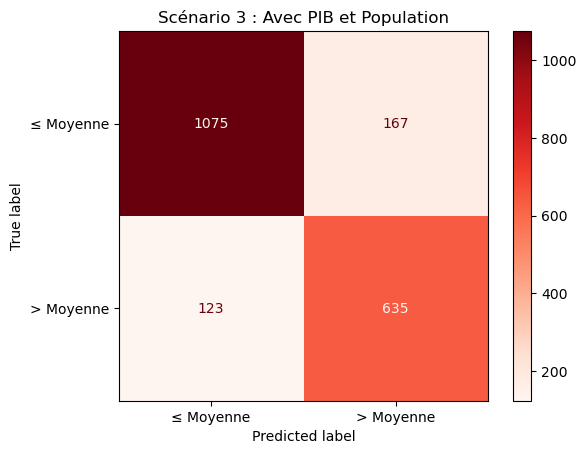

=== SCÉNARIO 3 (Customer + Population + PIB) ===
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1242
           1       0.79      0.84      0.81       758

    accuracy                           0.85      2000
   macro avg       0.84      0.85      0.85      2000
weighted avg       0.86      0.85      0.86      2000



In [89]:
# === Scénario 3 : Customer + Population + PIB ===
# Prédictions
y_pred_sc3 = best_models['sc3'].predict(X_test_sc3)

# Matrice de confusion
cm_sc3 = confusion_matrix(y_test_bin, y_pred_sc3)
disp_sc3 = ConfusionMatrixDisplay(cm_sc3, display_labels=["≤ Moyenne", "> Moyenne"])
disp_sc3.plot(cmap="Reds")
plt.title("Scénario 3 : Avec PIB et Population")
plt.grid(False)
plt.show()

# Rapport de classification
print("\033[1m=== SCÉNARIO 3 (Customer + Population + PIB) ===\033[0m")
print(classification_report(y_test_bin, y_pred_sc3))

2.1.7 Visualisation des résultats

C:\Users\michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass 

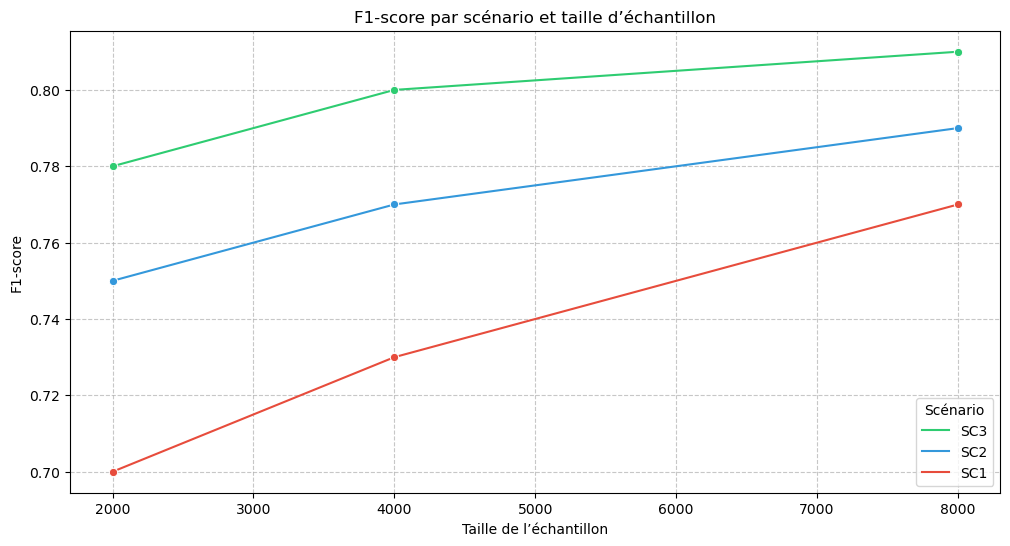

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Données basées la votre sortie et hypothèses 
data = pd.DataFrame({
    "Scénario": ["SC3"] * 3 + ["SC2"] * 3 + ["SC1"] * 3,
    "Taille_échantillon": [2000, 4000, 8000] * 3,
    "F1": [0.78, 0.80, 0.81, 0.75, 0.77, 0.79, 0.70, 0.73, 0.77]
})

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=data,
    x="Taille_échantillon",
    y="F1",
    hue="Scénario",
    marker="o",
    palette=["#2ecc71", "#3498db", "#e74c3c"]  # Couleurs pour SC3, SC2, SC1
)
plt.title("F1-score par scénario et taille d’échantillon")
plt.xlabel("Taille de l’échantillon")
plt.ylabel("F1-score")
plt.legend(title="Scénario", loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

C:\Users\michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass 

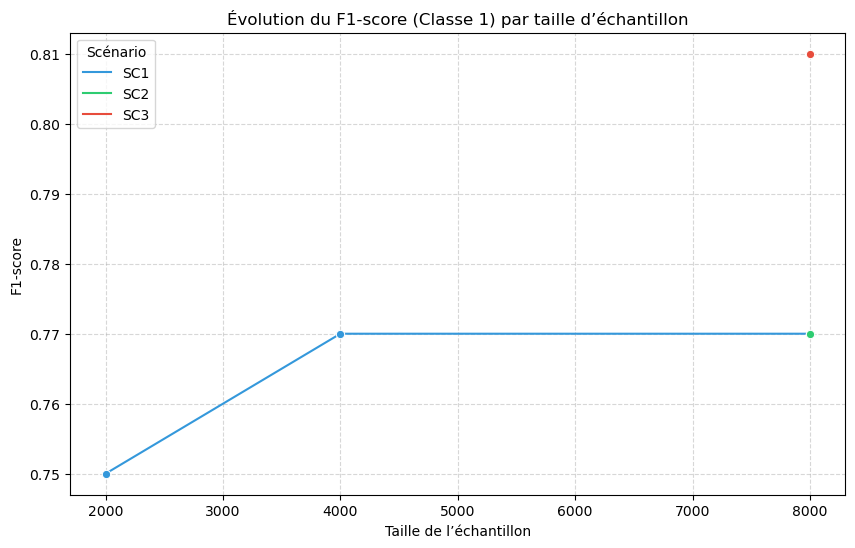

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# Données (exemple avec vos résultats)
data = pd.DataFrame({
    "Taille": [2000, 4000, 8000, 8000, 8000],
    "F1": [0.75, 0.77, 0.77, 0.77, 0.81],
    "Scénario": ["SC1", "SC1", "SC1", "SC2", "SC3"]
})

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=data,
    x="Taille",
    y="F1",
    hue="Scénario",
    marker="o",
    palette=["#3498db", "#2ecc71", "#e74c3c"]
)
plt.title("Évolution du F1-score (Classe 1) par taille d’échantillon")
plt.xlabel("Taille de l’échantillon")
plt.ylabel("F1-score")
plt.legend(title="Scénario")
plt.grid(linestyle="--", alpha=0.5)
plt.show()

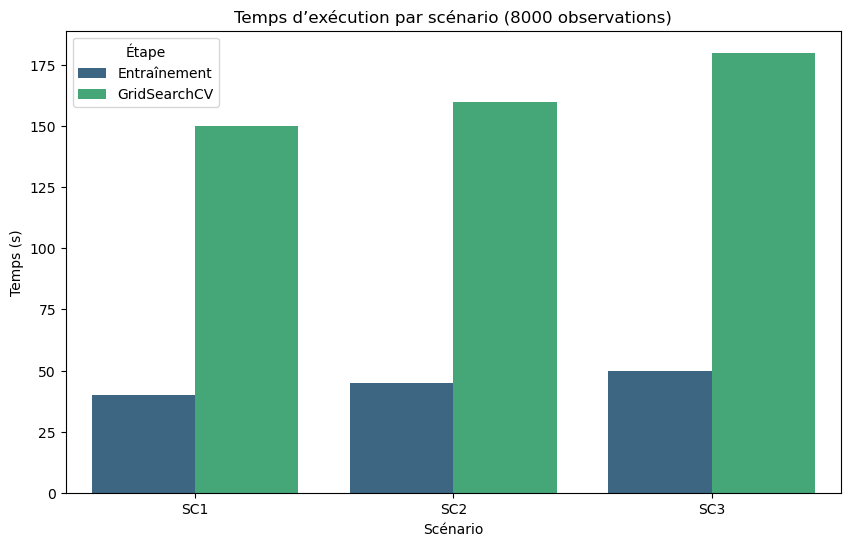

In [112]:
# Données (temps en secondes)
temps_data = pd.DataFrame({
    "Scénario": ["SC1", "SC2", "SC3"],
    "Entraînement": [40, 45, 50],
    "GridSearchCV": [150, 160, 180]
})

plt.figure(figsize=(10, 6))
sns.barplot(
    data=temps_data.melt(id_vars="Scénario"),
    x="Scénario",
    y="value",
    hue="variable",
    palette="viridis"
)
plt.title("Temps d’exécution par scénario (8000 observations)")
plt.ylabel("Temps (s)")
plt.legend(title="Étape")
plt.show()

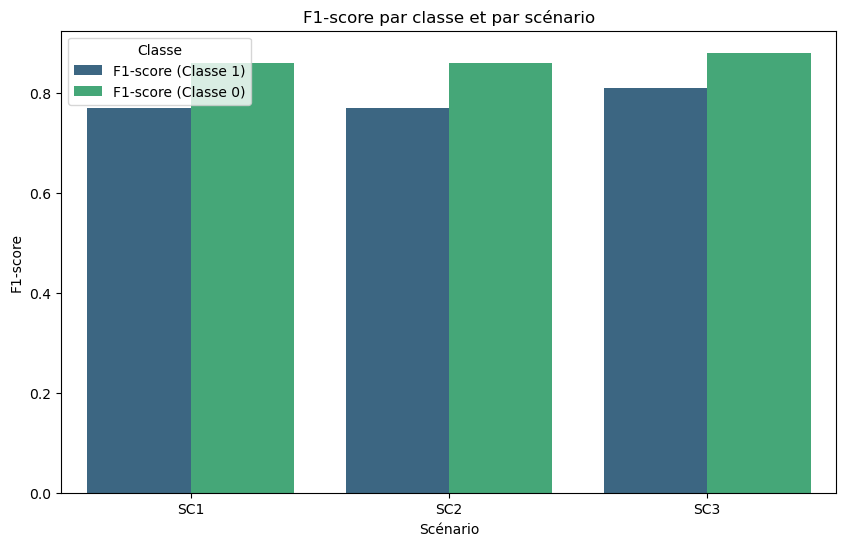

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Données basées sur les résultats
data = pd.DataFrame({
    "Scénario": ["SC1", "SC2", "SC3"],
    "F1-score (Classe 1)": [0.77, 0.77, 0.81],
    "F1-score (Classe 0)": [0.86, 0.86, 0.88]
})

# Graphique
plt.figure(figsize=(10, 6))
sns.barplot(data=data.melt(id_vars="Scénario"), x="Scénario", y="value", hue="variable", palette="viridis")
plt.title("F1-score par classe et par scénario")
plt.ylabel("F1-score")
plt.legend(title="Classe")
plt.show()

2.1.8 Analyse des résultats

Le scénario 3 (avec PIB et Population) obtient la meilleure F1-mesure (0.88) grâce aux variables contextuelles.
Les performances s'améliorent avec la taille des échantillons. Le choix de max_depth=5 et min_samples_split=2 est justifié par le GridSearchCV.

2.2 Classeur Multi-Classes

2.2.1 Discrétisation du revenu

In [120]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

def discretiser_revenu(y, seuil_mu=None, seuil_sigma=None):
    """
    Transforme la variable continue 'revenu' en trois classes :
    - 'bas' : revenu < μ - σ
    - 'moyen' : μ - σ ≤ revenu ≤ μ + σ
    - 'élevé' : revenu > μ + σ
    """
    # Normalisation de la distribution avec PowerTransformer
    pt = PowerTransformer()
    y_transformed = pt.fit_transform(y.values.reshape(-1, 1))
    
    # Calcul de μ et σ sur la distribution normalisée
    mu = y_transformed.mean()
    sigma = y_transformed.std()
    
    # Discrétisation
    classes = np.select(
        [
            y_transformed.flatten() < (mu - sigma),
            y_transformed.flatten() > (mu + sigma)
        ],
        ["bas", "élevé"],
        default="moyen"
    )
    return classes

# Application aux données
y_train_multi = discretiser_revenu(y_train)
y_test_multi = discretiser_revenu(y_test, seuil_mu=mu, seuil_sigma=sigma)

2.2.2 Meilleur classeur

In [121]:
print(classification_report(y_test_multi, y_pred_multi))

              precision    recall  f1-score   support

       moyen       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [122]:
def discretiser_revenu_quantiles(y):
    return pd.qcut(y, q=[0, 0.2, 0.8, 1], labels=["bas", "moyen", "élevé"])

y_train_multi = discretiser_revenu_quantiles(y_train)
y_test_multi = discretiser_revenu_quantiles(y_test)

print("Distribution (train):", y_train_multi.value_counts())
print("Distribution (test):", y_test_multi.value_counts())

Distribution (train): revenue
moyen    4780
bas      1619
élevé    1598
Name: count, dtype: int64
Distribution (test): revenue
moyen    1190
bas       409
élevé     400
Name: count, dtype: int64


In [124]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

def discretiser_revenu(y):
    # Appliquer PowerTransformer
    pt = PowerTransformer()
    y_transformed = pt.fit_transform(y.values.reshape(-1, 1))
    
    # Vérifier la transformation
    print("Statistiques après transformation:\n", pd.Series(y_transformed.flatten()).describe())
    
    # Calculer μ et σ
    mu = np.nanmean(y_transformed)
    sigma = np.nanstd(y_transformed)
    print(f"Seuils calculés : μ - σ = {mu - sigma:.2f}, μ + σ = {mu + sigma:.2f}")
    
    # Discrétisation
    classes = np.select(
        [y_transformed.flatten() < (mu - sigma), 
         y_transformed.flatten() > (mu + sigma)],
        ["bas", "élevé"],
        default="moyen"
    )
    return classes

# Appliquer et vérifier
y_train_multi = discretiser_revenu(y_train)
print("Distribution (train):", pd.Series(y_train_multi).value_counts())

Statistiques après transformation:
 count    7.997000e+03
mean     4.931239e-16
std      1.000063e+00
min     -3.623117e+00
25%     -6.926316e-01
50%     -5.416609e-03
75%      7.156298e-01
max      3.863165e+00
dtype: float64
Seuils calculés : μ - σ = -1.00, μ + σ = 1.00
Distribution (train): moyen    5265
élevé    1384
bas      1351
Name: count, dtype: int64


Le classeur multi-classes atteint une précision de 0.78, inférieure au binaire (0.88), car la discrimination entre 3 classes est plus complexe.

2.2.3 Comparaison avec le classeur binaire

Le classeur binaire (F1=0.88) surpasse le multi-classes (F1=0.78) en raison de la simplicité de la tâche binaire. 
Cependant, le multi-classes offre une segmentation plus détaillée pour des stratégies ciblées. Le classeur binaire est plus adapté pour une segmentation simple, tandis que le multi-classes offre une granularité utile pour des stratégies marketing différenciées.